In [1]:
%matplotlib inline

In [4]:
!pip install aif360
!pip install adversarial-robustness-toolbox
!pip install shap
!pip install BlackBoxAuditing
!pip install aif360[Reductions]

  Using cached aif360-0.6.1-py3-none-any.whl.metadata (5.0 kB)
Using cached aif360-0.6.1-py3-none-any.whl (259 kB)
  Using cached adversarial_robustness_toolbox-1.18.1-py3-none-any.whl.metadata (11 kB)
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ------------- ------------------------- 20.5/57.6 kB 54.5 kB/s eta 0:00:01
     ------------- ------------------------- 20.5/57.6 kB 54.5 kB/s eta 0:00:01
     --------------------------- ---------- 41.0/57.6 kB 115.5 kB/s eta 0:00:01
     --------------------------- ---------- 41.0/57.6 kB 115.5 kB/s eta 0:00:01
     --------------------------------- ---- 51.2/57.6 kB 100.6 kB/s eta 0:00:01
     -----------------------------

In [5]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

ModuleNotFoundError: No module named 'aif360'

In [ ]:
# Step 1: Download the file
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip

# Step 2: Unzip the file
!unzip bank-additional.zip -d bank-additional

# Step 3: Move the contents to the required directory
!mv bank-additional/bank-additional/* /usr/local/lib/python3.10/dist-packages/aif360/data/raw/bank/

# Step 4: Remove the zip file
!rm bank-additional.zip

--2024-09-29 04:29:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [ <=>                ] 434.15K  --.-KB/s    in 0.1s    

2024-09-29 04:29:15 (3.18 MB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/bank-additional/
  inflating: bank-additional/bank-additional/.DS_Store  
   creating: bank-additional/__MACOSX/
   creating: bank-additional/__MACOSX/bank-additional/
  inflating: bank-additional/__MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional/bank-add

To remove warnings:

In [ ]:
!pip install 'aif360[inFairness]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 33.8 MB/s eta 0:00:00


In [ ]:
%cd '/content/drive/MyDrive/Senior Design Project/mia-privacy-fairness'

/content/drive/MyDrive/Senior Design Project/mia-privacy-fairness


In [ ]:
from aif360.datasets import StandardDataset
StandardDataset??

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGRMitigator, PRMitigator, CPPMitigator, ROMitigator
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias

# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade ")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection'], default='label', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")


c:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\inFairness\utils\ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
c:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\inFairness\utils\ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrat

_StoreAction(option_strings=['-o', '--os'], dest='os', nargs=None, const=None, default=2, type=None, choices=None, required=False, help='oversample mode: 1: privi unfav 2: unpriv fav', metavar=None)

In [ ]:
import sys
sys.argv = ['']
args = vars(ap.parse_args(""))

In [ ]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'label',
 'os': 2}

In [ ]:
DATASET = "bank"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])

In [ ]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False
else:
    SCALER = False
DISPLAY = False
THRESH_ARR = 0.5

# loop ten times
N = 3
# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# running results over N runs
orig_metrics = defaultdict(list)
# for each pre-processing approach, we create a mia_metric_results
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list)
transf_mia_metrics = defaultdict(list)

reweigh_metrics = defaultdict(list)
reweigh_mia_metrics = defaultdict(list)

dir_metrics = defaultdict(list)
dir_mia_metrics = defaultdict(list)

egr_metrics = defaultdict(list)
egr_mia_metrics = defaultdict(list)


pr_orig_metrics = defaultdict(list)
cpp_metrics = defaultdict(list)
ro_metrics = defaultdict(list)

# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

# training data split ratio
p = 0.5

In [ ]:
dataset_orig.features.shape

(30488, 57)

In [ ]:
privileged_groups

[{'age': 1}]

In [ ]:
num_of_fav_labels = np.sum(dataset_orig.labels==1) #3859
num_of_unfav_labels = np.sum(dataset_orig.labels==0) #26629

print(num_of_fav_labels, num_of_unfav_labels)

3859 26629


In [ ]:
# split dataset into train, validation, and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
dataset_orig_val = dataset_orig_test
print(dataset_orig_train.features)

# favorable and unfavorable labels and feature_names
f_label = dataset_orig_train.favorable_label
uf_label = dataset_orig_train.unfavorable_label
feature_names = dataset_orig_train.feature_names

# introduce label or selection biases, assuming the original data is fair
if BIAS_TYPE == 'label':
    dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
elif BIAS_TYPE == 'selection':
    dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
else:
    print('no bias type specified')

# # show data info
# print("#### Training Dataset shape")
# print(dataset_orig_train.features.shape)
# print("#### Favorable and unfavorable labels")
# print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
# print("#### Protected attribute names")
# print(dataset_orig_train.protected_attribute_names)
# print("#### Privileged and unprivileged protected attribute values")
# print(privileged_groups, unprivileged_groups)
# #print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
# print("#### Dataset feature names")
# print(dataset_orig_train.feature_names)
# print(dataset_orig_train.features[0]) #:,4])

# # check fairness on the original data
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False))
base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
base_rate_privileged = metric_orig_train.base_rate(privileged=True)
print('base_pos unpriv: ', base_rate_unprivileged)
print('base_pos priv: ', base_rate_privileged)
#print(np.count_nonzero(dataset_orig_train.labels==f_label))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

# # statistics of favored/positive class BEFORE transf
# priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True)
# priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False)
# favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
# favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
# favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
# favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
# favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
# favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

# print("Train shape, validation shape, test shape")
# print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)


[[  1. 269.   3. ...   0.   1.   0.]
 [  1. 157.   3. ...   0.   1.   0.]
 [  1.  14.   9. ...   0.   1.   0.]
 ...
 [  1. 219.   2. ...   0.   1.   0.]
 [  1. 297.   2. ...   0.   1.   0.]
 [  1. 244.   1. ...   0.   1.   0.]]


In [ ]:
favor_metric_orig

defaultdict(float,
            {'total_favor': 0.12496720020991865,
             'total_unfavor': 0.8750327997900813,
             'priv_favor': 0.1216416902929661,
             'priv_unfavor': 0.8783583097070339,
             'unpriv_favor': 0.23953488372093024,
             'unpriv_unfavor': 0.7604651162790698})

In [ ]:
# dataset_orig_train

In [ ]:
dataset_orig_train?

In [ ]:
# run mitigating algorithms
for i in range(N):
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    #print(dataset_orig_train.features)

    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig_train.favorable_label
    uf_label = dataset_orig_train.unfavorable_label
    feature_names = dataset_orig_train.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected attribute values")
    print(privileged_groups, unprivileged_groups)
    #print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)
    print(dataset_orig_train.features[0]) #:,4])

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False))
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print(np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True)
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False)
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER)

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, OS_MODE, SCALER)
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER)

    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # egr mitigator, in-processing
    # egr_metrics = test_cases.run_egr(dataset_orig_train, dataset_orig_val, dataset_orig_test, egr_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups,THRESH_ARR, DISPLAY, SCALER)
    # egr gave error so I replaced it with reweigh
    egr_metrics, egr_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, egr_metrics, egr_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # cpp mitigator
    cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    # ro mitigator
    # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    if (BASELINE == 'lr'):
        pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER)



#### Training Dataset shape
(15244, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected attribute values
[{'age': 1}] [{'age': 0}]
#### Dataset feature names
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job=admin.', 'job=blue-collar', 'job=entrepreneur', 'job=housemaid', 'job=management', 'job=retired', 'job=self-employed', 'job=services', 'job=student', 'job=technician', 'job=unemployed', 'marital=divorced', 'marital=married', 'marital=single', 'education=basic.4y', 'education=basic.6y', 'education=basic.9y', 'education=high.school', 'education=illiterate', 'education=professional.course', 'education=university.degree', 'default=no', 'default=yes', 'housing=no', 'housing=yes', 'loan=no', 'loan=yes', 'contact=cellular', 'contact=telephone', 'month=apr', 'month=aug', 'month=dec', 'month=jul', 'month=jun', 'month=mar', 'mo

/usr/local/lib/python3.10/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


Best balanced accuracy: 0.5143
Corresponding 1-min(DI, 1/DI) value: 0.0000
Corresponding average odds difference value: 0.3354
Corresponding statistical parity difference value: 0.2235
Corresponding equal opportunity difference value: 0.5607
Corresponding Theil index value: 0.1314
#### Training Dataset shape
(15244, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected attribute values
[{'age': 1}] [{'age': 0}]
#### Dataset feature names
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job=admin.', 'job=blue-collar', 'job=entrepreneur', 'job=housemaid', 'job=management', 'job=retired', 'job=self-employed', 'job=services', 'job=student', 'job=technician', 'job=unemployed', 'marital=divorced', 'marital=married', 'marital=single', 'education=basic.4y', 'education=basic.6y', 'education=basic.9y', 'education=high.school', 'educatio

/usr/local/lib/python3.10/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


Best balanced accuracy: 0.5119
Corresponding 1-min(DI, 1/DI) value: 0.0000
Corresponding average odds difference value: 0.2983
Corresponding statistical parity difference value: 0.1987
Corresponding equal opportunity difference value: 0.4857
Corresponding Theil index value: 0.1310
#### Training Dataset shape
(15244, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected attribute values
[{'age': 1}] [{'age': 0}]
#### Dataset feature names
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job=admin.', 'job=blue-collar', 'job=entrepreneur', 'job=housemaid', 'job=management', 'job=retired', 'job=self-employed', 'job=services', 'job=student', 'job=technician', 'job=unemployed', 'marital=divorced', 'marital=married', 'marital=single', 'education=basic.4y', 'education=basic.6y', 'education=basic.9y', 'education=high.school', 'educatio

/usr/local/lib/python3.10/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


In [ ]:
priv_metric_orig1 = priv_metric_orig

In [ ]:
priv_metric_orig.values()

dict_values([[3.0114819895341154], [0.08641975308641975]])

In [ ]:
priv_metric_orig =priv_metric_orig1

In [ ]:
# display output

print('1)')
print(DATASET)
print(dataset_orig_train.features.shape[0])
print('\n2)')
# priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
priv_metric_orig = {k: [i/N for i in v] for (k,v) in priv_metric_orig.items()}

results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('\n3)')
# favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_orig = {k: [i/N for i in v] for (k,v) in favor_metric_orig.items()}

# favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
favor_metric_transf = {k: [i/N for i in v] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('\n\n\n4)')

# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
egr_error_metrics = {k: [statistics.stdev(v)] for (k,v) in egr_metrics.items()}
pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
egr_metrics_mean = {k:[sum(v)/N] for (k,v) in egr_metrics.items()}
pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

# print(len(orig_metrics_mean), len(transf_metrics_mean), len(dir_metrics_mean),
#       len(reweigh_metrics_mean), len(egr_metrics_mean), len(cpp_metrics_mean), len(ro_metrics_mean))


# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()



1)
bank
15244

2)
              total_priv  total_unpriv
num_instance                          
orig            0.037179      0.001067

3)
         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.000077       0.000532    0.000076      0.000534      0.000137   
transf      0.000171       0.001200    0.000171      0.001200      0.000171   

         unpriv_unfavor  
dataset                  
orig           0.000472  
transf         0.001200  



4)


# Visualization

In [ ]:
"""
# Visuazlization of Fairness
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        egr_metrics_mean,
        pr_orig_metrics_mean,
        cpp_metrics_mean,
        ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        egr_error_metrics,
        pr_orig_error_metrics,
        cpp_error_metrics,
        ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn']+ [model_type+'_dir']+ [model_type+'_rew']+ [model_type+'_egr']+ [model_type+'_pr']+ [model_type+'_cpp']+ [model_type+'_ro'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))
"""

In [ ]:
df

In [ ]:
# Visualization of MIA results

## Visualization of MIA Attacks against various Fairness Techniques

## Privacy risk subpopulations vs Fairness with cross validation

In [ ]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}


# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.523496,0.513309,0.599720,0.549787,0.624910,0.512549,0.599444
syn,0.519221,0.510842,0.583000,0.567077,0.661214,0.509671,0.580179
dir,0.521221,0.511720,0.598155,0.592550,0.670436,0.510218,0.595403
rew,0.524687,0.514632,0.602242,0.541800,0.608635,0.514203,0.603604


In [ ]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [ ]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [ ]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.549787,0.624910,0.512549,0.599444
syn,0.567077,0.661214,0.509671,0.580179
dir,0.592550,0.670436,0.510218,0.595403
rew,0.541800,0.608635,0.514203,0.603604


<Axes: xlabel='Classifier MIA Attacks'>

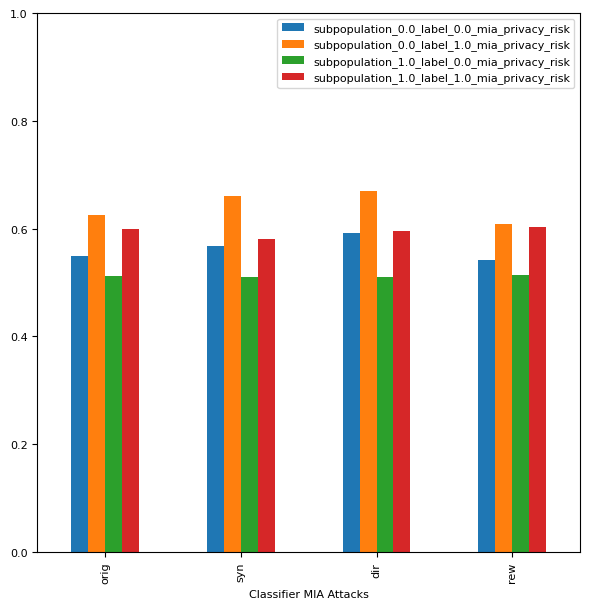

In [ ]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [ ]:
# Tabular Format
# importing the modules
from tabulate import tabulate


# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew
--------------------------------------------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.549787  0.567077  0.59255   0.5418
subpopulation_0.0_label_1.0_mia_privacy_risk  0.62491   0.661214  0.670436  0.608635
subpopulation_1.0_label_0.0_mia_privacy_risk  0.512549  0.509671  0.510218  0.514203
subpopulation_1.0_label_1.0_mia_privacy_risk  0.599444  0.580179  0.595403  0.603604


In [ ]:
# Visalizing using novel technique

In [ ]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])


In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.522501
1,orig,entire_dataset_mia_privacy_risk,0.522074
2,orig,entire_dataset_mia_privacy_risk,0.522074
3,orig,entire_dataset_label_0.0_mia_privacy_risk,0.513335
4,orig,entire_dataset_label_0.0_mia_privacy_risk,0.512911
...,...,...,...
79,dir,subpopulation_1.0_label_0.0_mia_privacy_risk,0.510875
80,dir,subpopulation_1.0_label_0.0_mia_privacy_risk,0.510875
81,dir,subpopulation_1.0_label_1.0_mia_privacy_risk,0.580866
82,dir,subpopulation_1.0_label_1.0_mia_privacy_risk,0.585712


In [ ]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.522501
1,orig,entire_dataset_mia_privacy_risk,0.522074
2,orig,entire_dataset_mia_privacy_risk,0.522074
9,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.538643
10,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.546109
11,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.546109
12,orig,subpopulation_0.0_label_1.0_mia_privacy_risk,0.594502
13,orig,subpopulation_0.0_label_1.0_mia_privacy_risk,0.628065
14,orig,subpopulation_0.0_label_1.0_mia_privacy_risk,0.628065
15,orig,subpopulation_1.0_label_0.0_mia_privacy_risk,0.512840


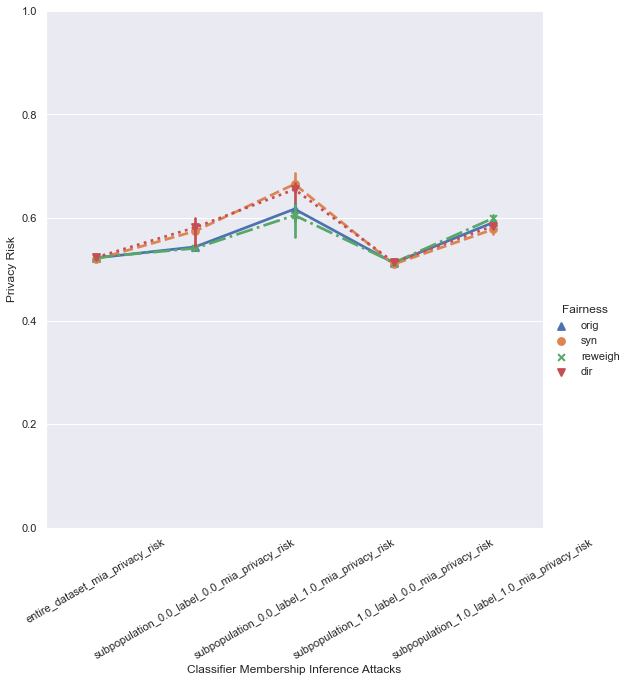

In [ ]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [ ]:
from sklearn.metrics import RocCurveDisplay, auc

In [ ]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

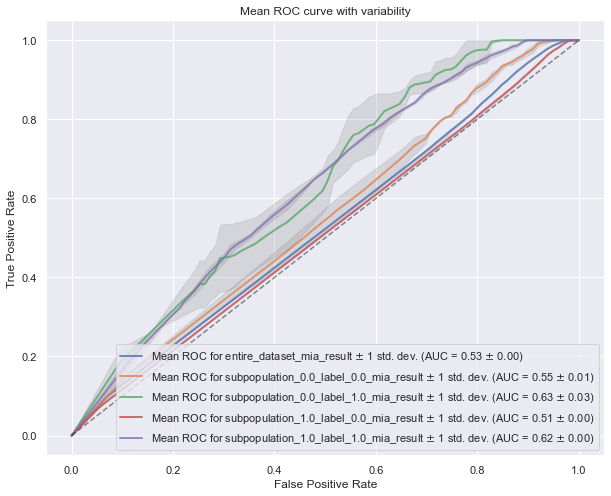

In [ ]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result", "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []

    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)

    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())

    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0

    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

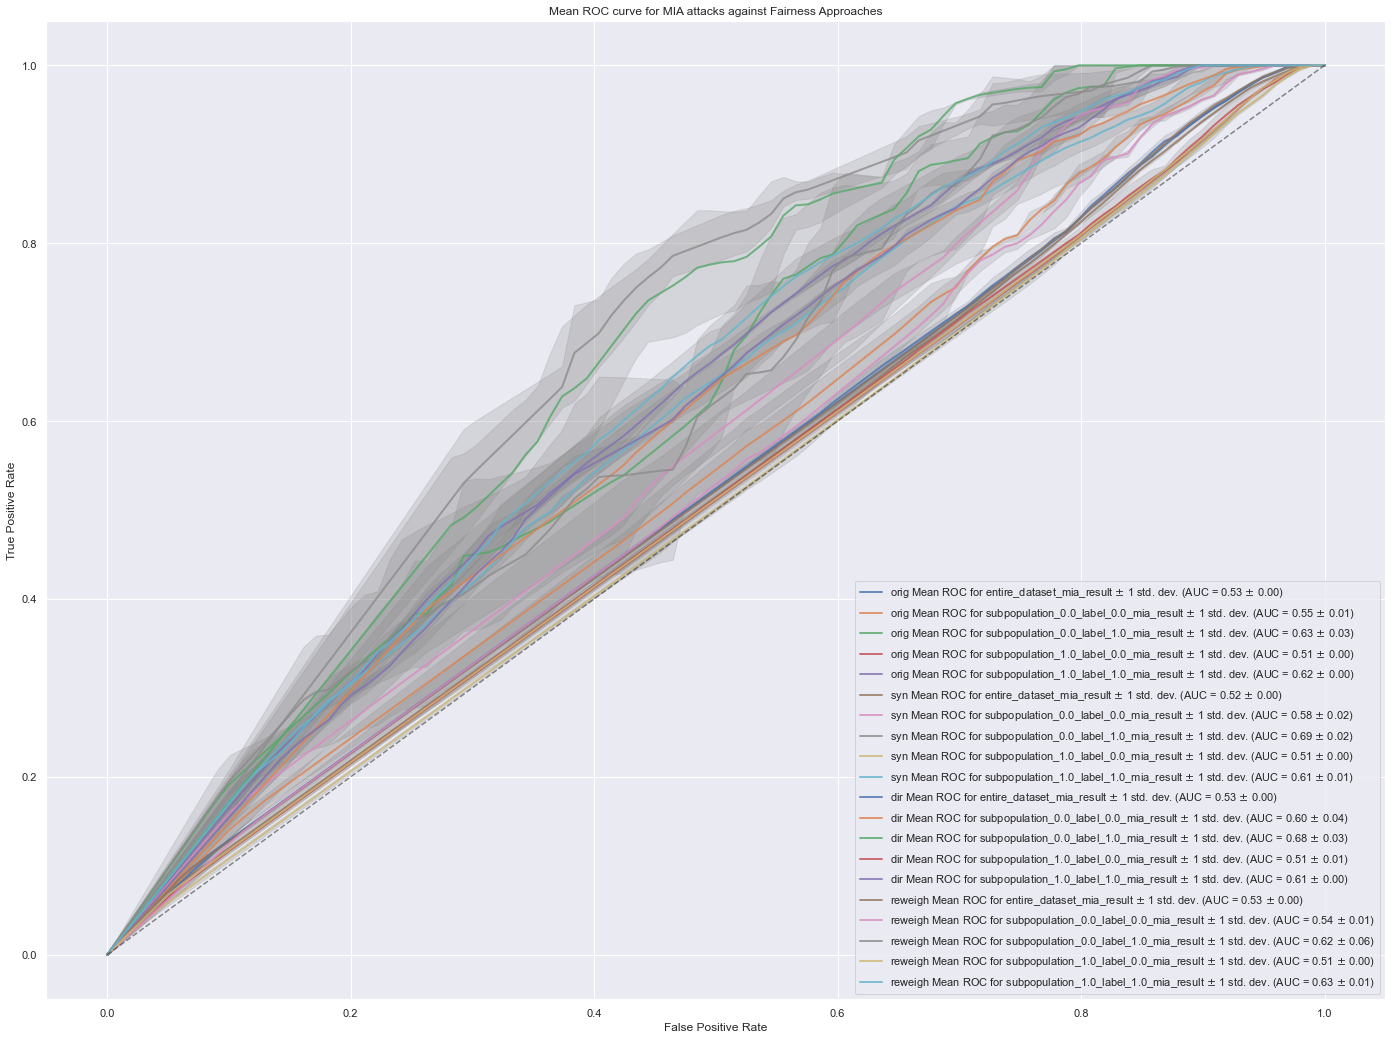

In [ ]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics, dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:

        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

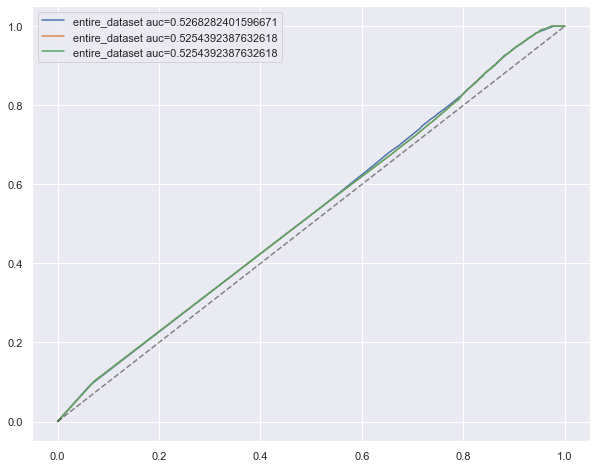

In [ ]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}


# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}

In [ ]:
orig_mia_metrics_mean

{'entire_dataset_mia_auc': 0.5259022392287303,
 'entire_dataset_label_0.0_mia_auc': 0.5135825896858878,
 'entire_dataset_label_1.0_mia_auc': 0.6248940791012355,
 'subpopulation_0.0_label_0.0_mia_auc': 0.5479931741722696,
 'subpopulation_0.0_label_1.0_mia_auc': 0.6292280237385589,
 'subpopulation_1.0_label_0.0_mia_auc': 0.5126833879512792,
 'subpopulation_1.0_label_1.0_mia_auc': 0.6246538834232124}

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.525902,0.513583,0.624894,0.547993,0.629228,0.512683,0.624654
syn,0.519188,0.507147,0.612649,0.577860,0.687462,0.505252,0.607767
dir,0.526652,0.517359,0.614238,0.604710,0.676995,0.514682,0.610973
rew,0.525511,0.514024,0.630077,0.535490,0.617044,0.513501,0.630756


<AxesSubplot:xlabel='Classifier MIA Attacks'>

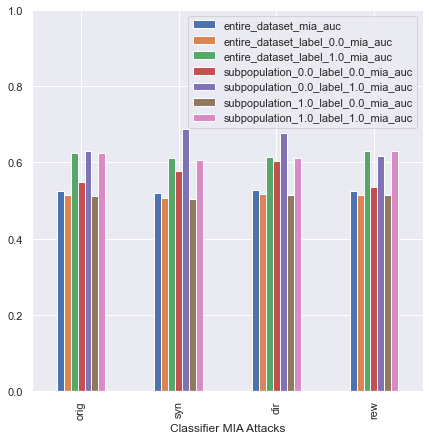

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [ ]:
# Creating data structures to plot point categorical plot from seaborn

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_att_ad

{'entire_dataset_mia_attacker_advantage': [0.04500131199160329,
  0.044148517449488334,
  0.044148517449488334],
 'entire_dataset_label_0.0_mia_attacker_advantage': [0.026670479483102305,
  0.025821590364842772,
  0.025821590364842772],
 'entire_dataset_label_1.0_mia_attacker_advantage': [0.1734386508357334,
  0.1864243139302857,
  0.1864243139302857],
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': [0.07728506787330314,
  0.09221701102801372,
  0.09221701102801372],
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': [0.18900343642611683,
  0.25612968591691987,
  0.25612968591691987],
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': [0.02567993075843944,
  0.02425695461893418,
  0.02425695461893418],
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': [0.1767417110330538,
  0.18420743743375112,
  0.18420743743375112]}

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.04500131199160329],
 ['orig', 'entire_dataset', 0.044148517449488334],
 ['orig', 'entire_dataset', 0.044148517449488334],
 ['orig', 'entire_dataset_label_0.0', 0.026670479483102305],
 ['orig', 'entire_dataset_label_0.0', 0.025821590364842772],
 ['orig', 'entire_dataset_label_0.0', 0.025821590364842772],
 ['orig', 'entire_dataset_label_1.0', 0.1734386508357334],
 ['orig', 'entire_dataset_label_1.0', 0.1864243139302857],
 ['orig', 'entire_dataset_label_1.0', 0.1864243139302857],
 ['orig', 'subpopulation_0.0_label_0.0', 0.07728506787330314],
 ['orig', 'subpopulation_0.0_label_0.0', 0.09221701102801372],
 ['orig', 'subpopulation_0.0_label_0.0', 0.09221701102801372],
 ['orig', 'subpopulation_0.0_label_1.0', 0.18900343642611683],
 ['orig', 'subpopulation_0.0_label_1.0', 0.25612968591691987],
 ['orig', 'subpopulation_0.0_label_1.0', 0.25612968591691987],
 ['orig', 'subpopulation_1.0_label_0.0', 0.02567993075843944],
 ['orig', 'subpopulation_1.0_label_0.0', 0.0242

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.045001
1,orig,entire_dataset,0.044149
2,orig,entire_dataset,0.044149
3,orig,entire_dataset_label_0.0,0.026670
4,orig,entire_dataset_label_0.0,0.025822
...,...,...,...
79,dir,subpopulation_1.0_label_0.0,0.021749
80,dir,subpopulation_1.0_label_0.0,0.021749
81,dir,subpopulation_1.0_label_1.0,0.161731
82,dir,subpopulation_1.0_label_1.0,0.171424


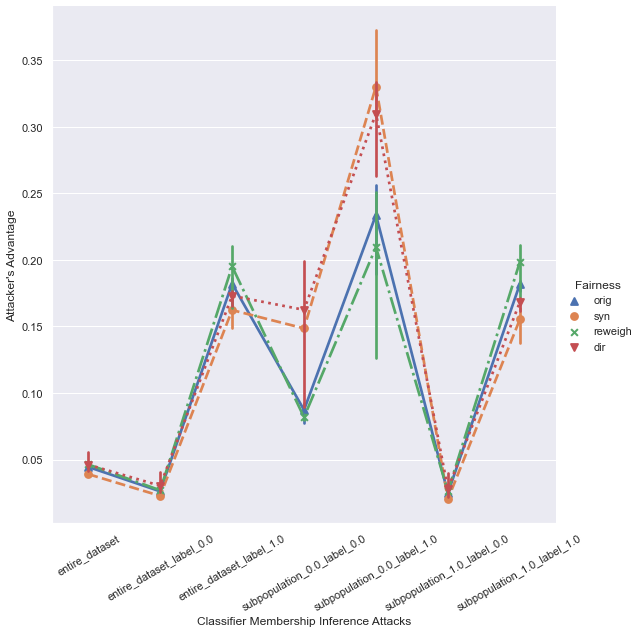

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


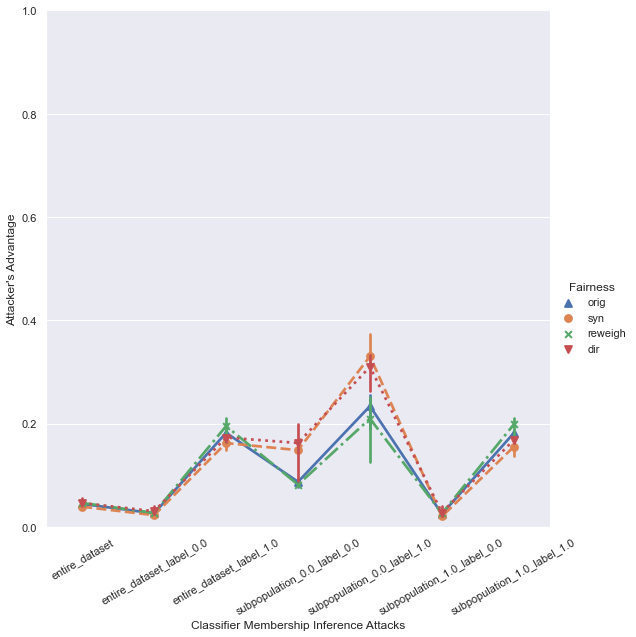

In [ ]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [ ]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.045001,0.026670,0.173439,0.077285,0.189003,0.025680,0.176742
1,0.044149,0.025822,0.186424,0.092217,0.256130,0.024257,0.184207
2,0.044149,0.025822,0.186424,0.092217,0.256130,0.024257,0.184207


In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}


# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}


In [ ]:
orig_mia_metrics_mean

{'entire_dataset_mia_attacker_advantage': 0.044432782296859985,
 'entire_dataset_label_0.0_mia_attacker_advantage': 0.026104553404262616,
 'entire_dataset_label_1.0_mia_attacker_advantage': 0.18209575956543492,
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': 0.0872396966431102,
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': 0.23375426941998553,
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': 0.024731279998769267,
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': 0.18171886196685202}

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,,,
orig,0.044433,0.026105,0.182096,0.087240,0.233754,0.024731,0.181719
syn,0.039032,0.022694,0.162247,0.148483,0.330127,0.020090,0.155189
dir,0.046160,0.030289,0.172933,0.162424,0.309851,0.027735,0.168193
rew,0.046313,0.026909,0.195020,0.081774,0.209523,0.026078,0.198333


<AxesSubplot:xlabel='Classifier MIA Attacks'>

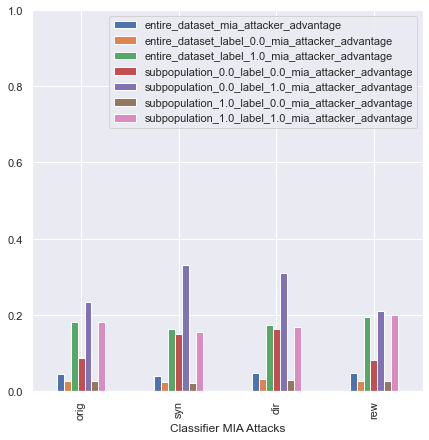

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5896898575020956],
 ['orig', 'entire_dataset', 0.5854025583145223],
 ['orig', 'entire_dataset', 0.5854025583145223],
 ['orig', 'entire_dataset_label_0.0', 0.5687815833801235],
 ['orig', 'entire_dataset_label_0.0', 0.5692216280451574],
 ['orig', 'entire_dataset_label_0.0', 0.5692216280451574],
 ['orig', 'entire_dataset_label_1.0', 0.6512396694214876],
 ['orig', 'entire_dataset_label_1.0', 0.6155572176514585],
 ['orig', 'entire_dataset_label_1.0', 0.6155572176514585],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5714285714285715],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5783132530120483],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5783132530120483],
 ['orig', 'subpopulation_0.0_label_1.0', 0.7],
 ['orig', 'subpopulation_0.0_label_1.0', 0.6103896103896105],
 ['orig', 'subpopulation_0.0_label_1.0', 0.6103896103896105],
 ['orig', 'subpopulation_1.0_label_0.0', 0.5686274509803921],
 ['orig', 'subpopulation_1.0_label_0.0', 0.56875],
 ['orig', 'subpopulation_1.0_

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.589690
1,orig,entire_dataset,0.585403
2,orig,entire_dataset,0.585403
3,orig,entire_dataset_label_0.0,0.568782
4,orig,entire_dataset_label_0.0,0.569222
...,...,...,...
79,dir,subpopulation_1.0_label_0.0,0.544070
80,dir,subpopulation_1.0_label_0.0,0.544070
81,dir,subpopulation_1.0_label_1.0,0.607090
82,dir,subpopulation_1.0_label_1.0,0.612717


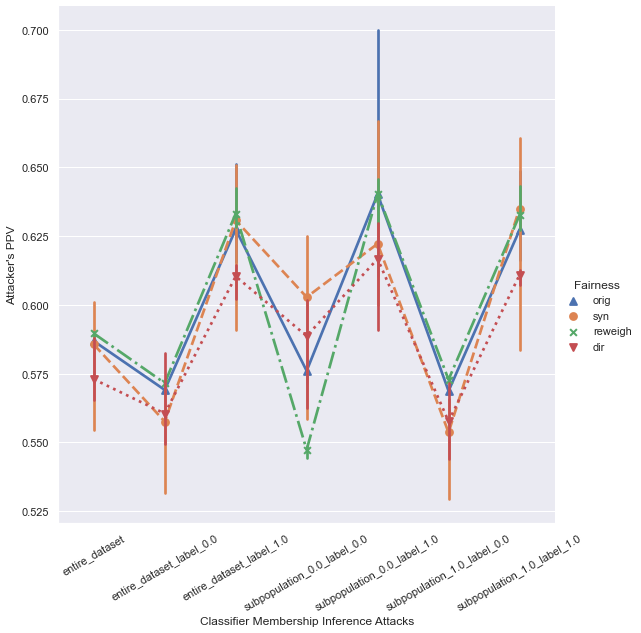

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [ ]:
import pandas as pd

In [ ]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month=sep,day_of_week=fri,day_of_week=mon,day_of_week=thu,day_of_week=tue,day_of_week=wed,poutcome=failure,poutcome=nonexistent,poutcome=success,labels
0,1.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,139.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,1.0,334.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
30484,1.0,383.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30485,1.0,189.0,2.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30486,1.0,442.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
df[["age", "labels"]].value_counts(normalize=True)

age  labels
1.0  0.0       0.851614
1.0  1.0       0.120047
0.0  0.0       0.021812
0.0  1.0       0.006527
dtype: float64

In [ ]:
df.drop_duplicates()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month=sep,day_of_week=fri,day_of_week=mon,day_of_week=thu,day_of_week=tue,day_of_week=wed,poutcome=failure,poutcome=nonexistent,poutcome=success,labels
0,1.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,139.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,1.0,334.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
30484,1.0,383.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30485,1.0,189.0,2.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30486,1.0,442.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
